In [5]:
# sampling methodology template script 
# 20230913
# carverd@colostate.edu

In [31]:
# libraries 
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import date
import ee
# ee.Authenticate()
ee.Initialize()


In [32]:
### 
# set sample grid ID 
aoiID = 'X12-677'
# set some basic parameter for workflow 
coordsAbsence = np.nan
coordsPresence = np.nan
today = date.today()

Today's date: 2023-10-11


In [5]:
# load the sampling reference grid 12kGrid
grid = gpd.read_file("../data/griddedFeatures/twelve_mi_grid_uid.gpkg")
# load the sampling grid 
df = pd.read_csv("../sampling/samplingReferenceSheet_12.csv", index_col='ID')

         presence2010  presence2015  presence2020  absence  sampledBy  \
ID                                                                      
X12-677           NaN           NaN           NaN      NaN        NaN   
X12-88            NaN           NaN           NaN      NaN        NaN   
X12-34            NaN           NaN           NaN      NaN        NaN   
X12-343           NaN           NaN           NaN      NaN        NaN   
X12-608           NaN           NaN           NaN      NaN        NaN   
X12-367           NaN           NaN           NaN      NaN        NaN   
X12-311           NaN           NaN           NaN      NaN        NaN   
X12-758           NaN           NaN           NaN      NaN        NaN   
X12-489           NaN           NaN           NaN      NaN        NaN   
X12-408           NaN           NaN           NaN      NaN        NaN   
X12-413           NaN           NaN           NaN      NaN        NaN   
X12-566           NaN           NaN           NaN  

<Axes: >

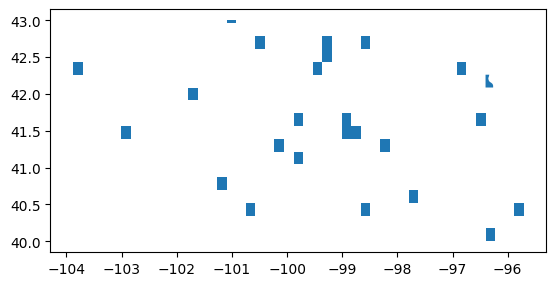

In [6]:
# quick map of the sampling locations 
mask = grid['Unique_ID'].isin(df.index)
sp1 = grid[mask]
sp1.plot()

In [8]:
# Generaete map objects based on the define reference grid 
### as geopandas class 
aoi_pandas = grid[grid.Unique_ID == aoiID]
### as ee object
aoi_ee = geemap.gdf_to_ee(aoi_pandas)


In [9]:
# compile naip imagery 
# 2010, 2016, 2020 for sample time periods 
naip2020 = geemap.get_annual_NAIP(2020).filterBounds(aoi_ee).mosaic()
naip2015 = geemap.get_annual_NAIP(2016).filterBounds(aoi_ee).mosaic()
naip2010 = geemap.get_annual_NAIP(2010).filterBounds(aoi_ee).mosaic()
# print(naip2020)


In [10]:
# compile Naip visualizations 
visParamsFalse = {"bands":['N', 'R', 'G']};
visParamsTrue = {"bands":['R', 'G', 'B']};



In [26]:
### Tree presence sampling 
MapPresence = geemap.Map()
MapPresence.add_basemap("SATELLITE")
MapPresence.centerObject(ee_object = aoi_ee, zoom = 10)
MapPresence.addLayer(naip2020, visParamsTrue, name = "rgb2020")
MapPresence.addLayer(naip2020, visParamsFalse, name = "false2020")
# testing the 2015 layer
MapPresence.addLayer(naip2015, visParamsTrue, name = "rgb2015")
MapPresence.addLayer(naip2010, visParamsTrue, name = "rgb2010")

MapPresence

Map(center=[42.69574620931511, -100.48851190949973], controls=(WidgetControl(options=['position', 'transparent…

In [42]:
# extract presence objects 
presence = ee.FeatureCollection(MapPresence.draw_features)
coordsPresence = geemap.ee_to_geojson(presence)


TypeError: '_iAtIndexer' object is not callable

In [27]:
### 2020 absence sampling 
MapAbsence = geemap.Map()
MapAbsence.add_basemap("SATELLITE")
MapAbsence.centerObject(ee_object = aoi_ee, zoom = 10)
MapAbsence.addLayer(naip2020, visParamsTrue, name = "rgb2020")
MapAbsence.addLayer(naip2020, visParamsFalse, name = "false2020")
# testing the 2015 layer
MapAbsence.addLayer(naip2015, visParamsTrue, name = "rgb2015")
MapAbsence.addLayer(naip2010, visParamsTrue, name = "rgb2010")

MapAbsence

Map(center=[42.69574620931511, -100.48851190949973], controls=(WidgetControl(options=['position', 'transparent…

In [22]:
# extract absence objects 
absence = ee.FeatureCollection(MapAbsence.draw_features)
coordsAbsence = geemap.ee_to_geojson(absence)
print(coordsAbsence)

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-100.570233, 42.588334]}, 'id': '0', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-100.576069, 42.575695]}, 'id': '1', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-100.607309, 42.568363]}, 'id': '2', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-100.614862, 42.581256]}, 'id': '3', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-100.615892, 42.626743]}, 'id': '4', 'properties': {}}]}


In [116]:
# binding values to the specific locations 
if 


df

,presence2010,presence2015,presence2020,absence,sampledBy,dateSampled
ID,,,,,,
X12-677,NaN,NaN,NaN,NaN,NaN,NaN
X12-88,NaN,NaN,NaN,NaN,NaN,NaN
X12-34,NaN,NaN,NaN,NaN,NaN,NaN
X12-343,NaN,NaN,NaN,NaN,NaN,NaN
X12-608,NaN,NaN,NaN,NaN,NaN,NaN
X12-367,NaN,NaN,NaN,NaN,NaN,NaN
X12-311,NaN,NaN,NaN,NaN,NaN,NaN
X12-758,NaN,NaN,NaN,NaN,NaN,NaN
X12-489,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# assign coords to the dataframe 
# df.loc("ID" == aoiID,"presence2020") # = coords
aoiID
df.iloc(aoiID)

ValueError: No axis named X12-677 for object type DataFrame